In [28]:
import re
import os.path
import fnmatch
import numpy as np
import matplotlib.pyplot as plt # after importting matplotlib, mayavi can not set api to 2: first run mayavi!!!!
from latexify import latexify
import scipy.io
from scipy import ndimage
from smoothn import smoothn
%matplotlib notebook

<IPython.core.display.Javascript object>


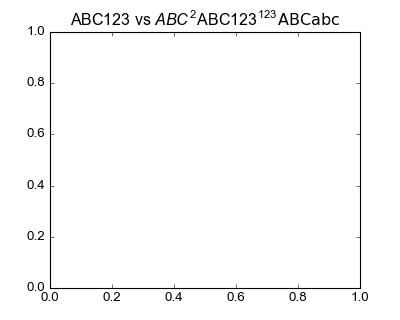

'If you want the regular text to look like the mathtext text, \nyou can change everything to Stix. This will affect labels, titles, ticks, etc.'

In [398]:
import matplotlib
'''To make the tex-style/mathtext text look like the regular text, 
you need to set the mathtext font to Bitstream Vera Sans:'''

matplotlib.rcParams['mathtext.fontset'] = 'custom'
# set the font
plt.rcParams["font.family"] = 'arial' #'Bitstream Vera Sans'# 'arial' #
matplotlib.rcParams['mathtext.rm'] = 'arial' #'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'arial:italic' #'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'arial:bold' #'Bitstream Vera Sans:bold'
fig, ax = plt.subplots(figsize=(5, 4))
matplotlib.pyplot.title(r'ABC123 vs $ABC^2\mathrm{ABC123}^{123}\mathsf{ABCabc}$')

'''If you want the regular text to look like the mathtext text, 
you can change everything to Stix. This will affect labels, titles, ticks, etc.'''

# matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['font.family'] = 'arial' #'STIXGeneral'
# matplotlib.pyplot.text(0.,0.5,r'ABC123 vs $\mathrm{ABC123}^{123}\mathsf{ABCabc}$')

#plt.style.use(u'classic')#u'seaborn-paper') # Set back to default

In [14]:
lam = np.array([0.248,0.196,0.177]) # \AA
lam/(2*np.sin(4.0/180.*3.14))

array([ 1.77851296,  1.40559895,  1.26934191])

In [36]:
def read_spe(fpath):
    '''Read the spe inelastic neutron scttering data exported by MSlice
    1. the empty grid is set to -1.00;
    '''
    with open(fpath, 'rU') as f:
        i = 0
        qs, es, data, error = [],[],[],[]
        for line in f: 
            line = line.rstrip('\n')
            if i==0:
                shape = np.array(line.split(),dtype='int'); print('Data shape: ', shape)        
                i+=1
                continue
                #data, error = np.empty(shape), np.empty(shape)
            if line==r'### |Q| (\AA!U-1!N)': # not use line.rstrip('\n').split()[1]=='\Q\' becasue stimes len(line)=1
                readQ, readE, readI, readEr = True, False, False, False
                continue
            if line==r'### E (meV)':
                readQ, readE, readI, readEr = False, True, False, False
                continue
            if line==r'### Intensity (arb. units)':
                readQ, readE, readI, readEr = False, False, True, False
                continue
            if line==r'### Errors':
                readQ, readE, readI, readEr = False, False, False, True
                continue
            if readQ:
                #qs.append(np.array(line, dtype='f')); continue
                qs.append(line.split()); continue
            if readE:
                es.append(line.split()); continue
            if readI:
                data.append(line.split()); continue
            if readEr:
                error.append(line.split()); continue
        #return np.array(qs),np.array(es),np.array(data).reshape(shape),np.array(error).reshape(shape)
        return np.array(np.concatenate(qs),dtype='f')[:-1], \
               np.array(np.concatenate(es),dtype='f')[:-1], \
               np.array(np.concatenate(data),dtype='f').reshape(shape), \
               np.array(np.concatenate(error),dtype='f').reshape(shape)
# without the last 0.000

def binning2D(x,y,D, xybins):
    '''Try to flatten the 2D data first and then to histogram2d
    but nan weight is not take cared
    The nb of elements in each bin at least larger than one (xybins<[len(x),len(y)])'''
    
    X, Y = np.meshgrid(x,y)
    
    xx, yy, dd = X.flatten(), Y.flatten(), D.T.flatten() 
    # use reshape([1,-1]) not working for it && must add '.T' (so that coresponding reightly)
    #print xx, yy, dd 
    
    xbin_no_pts= np.histogram(x, xybins[0])[0] #the no of data points in every bin
    ybin_no_pts= np.histogram(y, xybins[1])[0]
    
    if 0 in np.concatenate([xbin_no_pts, ybin_no_pts]):
        print("There are bins contanining 0 nb, desrease nb of bins;\nThe orginal data is returned")
        return x, y, data
    else:
        binxy_no_pts = xbin_no_pts.reshape(xybins[0],1).dot(ybin_no_pts.reshape(1,xybins[1])) #2D: nb of point per xy bin

        binx = np.histogram(x, bins=xybins[0],weights=x)[0]/ xbin_no_pts
        biny = np.histogram(y, bins=xybins[1],weights=y)[0]/ ybin_no_pts
        
        binD = np.histogram2d(xx,yy, bins=xybins, normed=False, weights=dd)[0]/binxy_no_pts
        return binx, biny,  binD

def binning2Dloop(x,y,D, xbins,ybins): # x and y are 1 by m or n arrays, D is m by n 2D data
    '''do not take care of Nan wight!!!'''
    xlen, ylen, ddim = len(x), len(y), D.shape
    #print xlen, ylen, ddim
    assert [xlen, ylen] == [ddim[0],ddim[1]]

    xbin_no_pts= np.histogram(x, xbins)[0] #the no of data points in every bin
    ybin_no_pts= np.histogram(y, ybins)[0]
    #print "binning scheme:"; print xbin_no_pts, ybin_no_pts
    
    binx = np.histogram(x,xbins,weights=x)[0] / xbin_no_pts
    biny = np.histogram(y,ybins,weights=y)[0] / ybin_no_pts    

    Dbinx = np.array([ np.histogram(x, xbins, weights=D[:,i])[0] / xbin_no_pts for i in range(ddim[1])]) # shape:[ylen,xbins]
    Dbiny = np.array([ np.histogram(y, ybins, weights=Dbinx[:,i])[0] / ybin_no_pts for i in range(xbins)]) #shape:[xbins,ybins]

# try to take care of nan: failed
#     keep = ~np.isnan(D)
    
#     Dbinx = np.array([ np.histogram(x[keep[:,i]], xbins, weights=D[keep[:,i],i])[0] / xbin_no_pts 
#                       for i in range(ddim[1])]) # shape:[ylen,xbins]
#     Dbiny = np.array([ np.histogram(y[keep[i,:]], ybins, weights=Dbinx[keep[i,:],i])[0] / ybin_no_pts 
#                       for i in range(xbins)]) #shape:[xbins,ybins]
    
    return binx, biny, Dbiny

from scipy import ndimage
def myGfilter(U, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0,nanout=1): 
    #Gaussian filter with igonoring 'nan'
    #https://stackoverflow.com/questions/18697532/gaussian-filtering-a-image-with-nan-in-python
    
    nans = U!=U # positions of nan: nan is not equal to nan
    V=U.copy()
    V[nans]=0 # replace 'nan' by 'zero'
    VV=ndimage.gaussian_filter(V, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)

    W=0*U.copy()+1 
    W[nans]=0 # label 'nan' and values with '0' and '1' respectively
    WW=ndimage.gaussian_filter(W, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
    
    output = VV/WW
    if nanout:
        output[nans] = np.nan
    return output

# Test binnging2D()
N,M = 10,6
data = np.reshape(np.arange(N*M),(N,M))
x, y = np.arange(N),np.arange(M)
print(x, y)
print(data)
binning2D(x,y, data, [11,6])

[0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5]
[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]
 [36 37 38 39 40 41]
 [42 43 44 45 46 47]
 [48 49 50 51 52 53]
 [54 55 56 57 58 59]]
There are bins contanining 0 nb, desrease nb of bins;
The orginal data is returned


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5]),
 array([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35],
        [36, 37, 38, 39, 40, 41],
        [42, 43, 44, 45, 46, 47],
        [48, 49, 50, 51, 52, 53],
        [54, 55, 56, 57, 58, 59]]))

In [82]:
a = [[1,2],[2,[4,3]]]; b = [2,3]; c = [4,5]; d = [[1,2],[2,3]];

e = [np.array([1,2]),np.array([2,3,5])]
#print np.concatenate([c, b])
#print a+b,np.concatenate(a+b)
import itertools
list(itertools.chain(*d))

print(list(itertools.chain(*a)))

print(np.ravel(d), np.concatenate(d))
print(np.concatenate(e),np.ravel(e),np.hstack(e))
#np.array(a)
#print(sum(a,[]))

[1, 2, 2, [4, 3]]
[1 2 2 3] [1 2 2 3]
[1 2 2 3 5] [array([1, 2]) array([2, 3, 5])] [1 2 2 3 5]


In [3]:
# Test load and plot
fpath = r'D:\5_Neutron Scattering\1_US ARCS_oct2014\data_2d_for_plot/'
fname = r'nzo_50mev_5k.spe'
filename = os.path.join(fpath,fname)
qs, es, data, error = read_spe(filename)
print qs.shape,es.shape, data.shape, error.shape

#data = np.where(data==-1.00, np.nan, data)

xbins,ybins = 198, 138
#qs, es, data = binning2Dloop(qs, es, data, xbins,ybins)
qs, es, data = binning2D(qs, es, data, [xbins,ybins])
#print qs, es, data
X, Y = np.meshgrid(qs,es)

Data shape:  [199 140]
(199L,) (140L,) (199L, 140L) (199L, 140L)
There are bins contanining 0 nb, desrease nb of bins;
The orginal data is returned


<IPython.core.display.Javascript object>


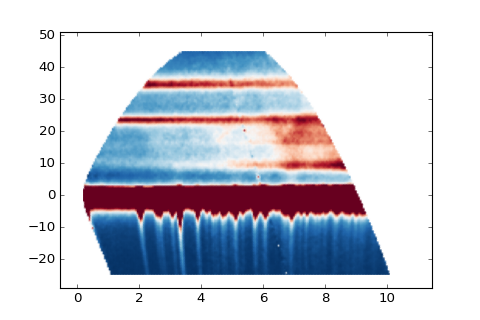

In [4]:
fig = plt.figure(figsize=(6,4))
# pcolormesh actually draws individual rectangles which contains white lines
cmap = plt.cm.RdBu_r
#cmap = plt.cm.jet
cmap.set_bad('w',1.)
Zm = np.ma.masked_where(data==-1.00,data)# mask Nan values then plot in white color
pcol = plt.pcolormesh(X,Y, Zm.T,vmin=0,vmax=0.00025, cmap=cmap,linewidth=0,rasterized=True,shading='gouraud')# '_r' is reversed colormap
pcol.set_edgecolor('face') # remove the white lines in the plot
plt.show()

In [6]:
#　Ｇｅｔ　ｔｈｅ　ｄａｔａ　ｆｉｌｅ　ｐａｔｈ
fpath = r'D:\5_Neutron Scattering\1_US ARCS_oct2014\data_2d_for_plot/'
fname = r'*.spe'

ii=0 #index for different files
fnames = []
for file in os.listdir(fpath):
    if fnmatch.fnmatch(file, fname):
        print(file)
        fnames.append(os.path.join(fpath,file))
        
print(fnames[0])

lzo_150mev_5k.spe
lzo_400mev_5k.spe
lzo_50mev_5k.spe
nzo_150mev_5k.spe
nzo_400mev_5k.spe
nzo_50mev_5k.spe
D:\5_Neutron Scattering\1_US ARCS_oct2014\data_2d_for_plot/lzo_150mev_5k.spe


In [45]:
# Ｌｏａｄ　ａｎｄ　ｐｌｏｔ
labels = ['150 meV', '400 meV', '50 meV']
x_lims = np.array([[0,16],   [0,26],   [0,9]])
y_lims = np.array([[-10,130],[-20,350],[-3,45]])
v_maxs = [1.,0.05,3.0]
texts = [r'La$_2$Zr$_2$O$_7$',r'La$_2$Zr$_2$O$_7$',r'La$_2$Zr$_2$O$_7$',
         r'Nd$_2$Zr$_2$O$_7$',r'Nd$_2$Zr$_2$O$_7$',r'Nd$_2$Zr$_2$O$_7$']

cmap = plt.cm.RdBu_r
cmap = plt.cm.jet
#cmap.set_bad('w',1.)

nb_of_files = 6
smooth = 0
for i in np.arange(0,6,1):
    print(fnames[i])
    idx = np.remainder(i,3)
    qs, es, data, error = read_spe(fnames[i])
    
    X, Y = np.meshgrid(qs,es)
    #data_view = np.where(data==-1.00,np.nan, data)# Set the empty point to nan for smoothing
    #Z,s,exitflag,Wtot = smoothn(data_view,s=smooth) # But smooth does not fill the gap! So export good data!!
    Zm = np.ma.masked_where(data==-1.00,data)# mask Nan values then plot in white color
    
    fig = plt.figure(figsize=(6,4))
    pcol = plt.pcolormesh(X,Y, Zm.T*10000,vmin=0,vmax=v_maxs[idx], cmap=cmap,linewidth=0,rasterized=True,shading='gouraud')# '_r' is reversed colormap
    pcol.set_edgecolor('face') # remove the white lines in the plot
    
    plt.text(0.77, 0.9, r'$E_\mathrm{i}=$'+'\n'+labels[idx] ,size=15,color='black', ha='left', va='center',transform=plt.gca().transAxes,
             backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))   
    plt.text(0.14, 0.9, texts[i] ,size=15,color='black', ha='center', va='center',transform=plt.gca().transAxes,
             backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))
    cb = plt.colorbar(aspect=20,pad=0.05,orientation="vertical") # label='Intensity', ticks=range(0,100)
    
    plt.minorticks_on()
    plt.xticks( color='k', size=14)
    plt.yticks( color='k', size=14)
    
    plt.xlim(x_lims[idx,:])
    plt.ylim(y_lims[idx,:])
    plt.xlabel(r'$Q\ (\mathrm{\AA^{-1}})$',size=14)
    plt.ylabel(r'$E$ (meV)',size=14)
    
    #fig.savefig(fnames[i].replace("spe", "pdf"), bbox_inches="tight",verbose=True)  
    
    plt.show()

D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SmHfO_analysis/lho_6k.mat


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 'U' mode is deprecated
  """


UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 148: character maps to <undefined>

# Load Sm2Hf2O7 Merlin data exported form Matlab Mslice (.mat files)

In [14]:
#　Ｇｅｔ　ｔｈｅ　ｄａｔａ　ｆｉｌｅ　ｐａｔｈ
fpath = r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SmHfO_analysis/'
fname = r'*.mat'

ii=0 #index for different files
fnames = []
for file in os.listdir(fpath):
    if fnmatch.fnmatch(file, fname):
        print(file)
        fnames.append(os.path.join(fpath,file))
        
print(fnames[0])

lho_6k.mat
sho_6k.mat
D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SmHfO_analysis/lho_6k.mat


D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SmHfO_analysis/lho_6k.mat


<IPython.core.display.Javascript object>


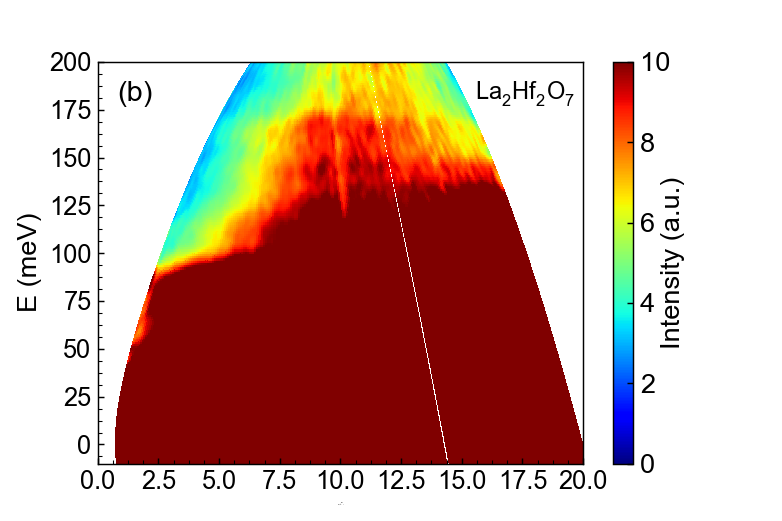

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SmHfO_analysis/sho_6k.mat


<IPython.core.display.Javascript object>


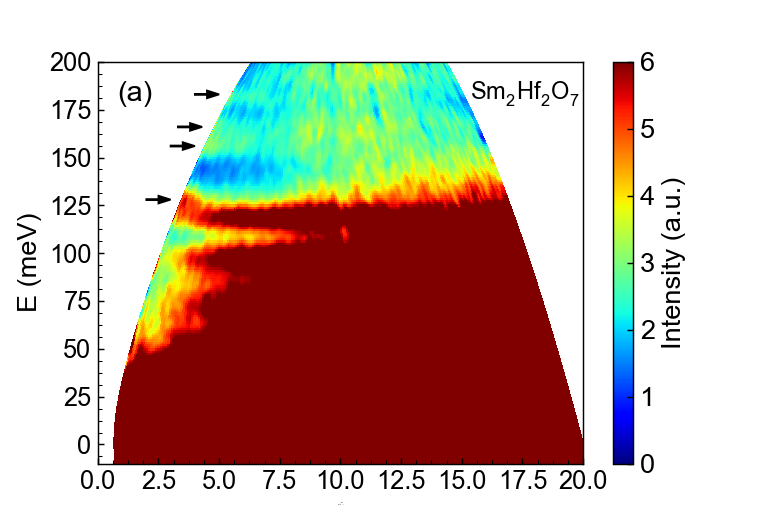

In [100]:
# Ｌｏａｄ
labels = ['241 meV', '241 meV', '50 meV']
x_lims = np.array([[0,20],   [0,20]])
y_lims = np.array([[-10,200],[-10,200]])
v_maxs = [10, 6]
texts0 = ['(b)','(a)']
texts1 = [r'La$_2$Hf$_2$O$_7$',r'Sm$_2$Hf$_2$O$_7$']

cmap = plt.cm.RdBu_r
cmap = plt.cm.PiYG_r
cmap = plt.cm.jet
cmap.set_bad('w',0.)

latexify()

nb_of_files = 2
smooth = 1
for i in np.arange(0,nb_of_files,1):
    print(fnames[i])
    idx = np.remainder(i,3)
    data = scipy.io.loadmat(fnames[i])
    
    X, Y, Z = data['X'], data['Y'], data['Z']
    #data_view = np.where(data==-1.00,np.nan, data)# Set the empty point to nan for smoothing
    #Z,s,exitflag,Wtot = smoothn(Z,s=smooth) # But smooth does not fill the gap! So export good data!!
    #Z = ndimage.gaussian_filter(Z, [1,1], order=0, mode='nearest', cval=0.0, truncate=4.0)
    #print(Z)
    
    Z = myGfilter(Z, [2,2],)
    #Zm = np.ma.masked_where(data==-1.00,data)# mask Nan values then plot in white color
    
    fig = plt.figure(figsize=(6,4))
    #pcol = plt.pcolormesh(X,Y, Z*1,vmin=0,vmax=v_maxs[idx], cmap=cmap,linewidth=0,rasterized=True,shading='gouraud')# '_r' is reversed colormap
    pcol = plt.pcolor(X,Y, Z*1,vmin=0,vmax=v_maxs[idx], cmap=cmap,linewidth=0,rasterized=True)# here we used pcolor to avoid whitelines
    pcol.set_edgecolor('face') # remove the white lines in the plot
    
#     plt.text(0.77, 0.92, r'$E_\mathrm{i}=$'+'\n'+labels[idx] ,size=15,color='black', ha='left', va='center',transform=plt.gca().transAxes,
#              backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))   
#     plt.text(0.14, 0.92, texts1[i] ,size=15,color='black', ha='center', va='center',transform=plt.gca().transAxes,
#              backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))
    plt.text(0.04, 0.92, texts0[i] ,size=16,color='black', ha='left', va='center',transform=plt.gca().transAxes,
             backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))   
    plt.text(0.88, 0.92, texts1[i] ,size=13,color='black', ha='center', va='center',transform=plt.gca().transAxes,
             backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))
    if i==1:
        plt.arrow(2,128,0.5,0,width=0.5,head_width=4,head_length=0.5,facecolor='k')
        plt.arrow(3,156,0.5,0,width=0.5,head_width=4,head_length=0.5,facecolor='k')
        plt.arrow(3.3,166,0.5,0,width=0.5,head_width=4,head_length=0.5,facecolor='k')
        plt.arrow(4,183,0.5,0,width=0.5,head_width=4,head_length=0.5,facecolor='k')
        
    cb = plt.colorbar(aspect=20,pad=0.05,orientation="vertical")#, ticks=range(0,100)
    cb.ax.set_ylabel('Intensity (a.u.)',fontsize=15)
    if i==0:
        cb.ax.set_ylabel('Intensity (a.u.)',fontsize=15,labelpad=-5)# because '10' takes more space
    cb.ax.tick_params(labelsize=15) 
    
    plt.minorticks_on()
    plt.xticks(color='k', size=14)
    plt.yticks(color='k', size=14)
    
    plt.xlim(x_lims[idx,:])
    plt.ylim(y_lims[idx,:])
    plt.xlabel(r'Q $(\mathrm{\AA^{-1}})$',size=1)
    plt.ylabel(r'E (meV)',size=15)
    
    fig.savefig(fnames[i].replace("mat", "pdf"), bbox_inches="tight",pad_inches=0.01,verbose=True)  
    
    plt.show()

## Below is trying to use RE to read SPE
but the last data set cannot use a simple pattern to find

Winexpect_call_spectra.py also used re.

re tricks:
1. The special characters you should use \ in prefix: \\ for \, \! for !, \[,\( ...
2. The part in brackets of the pattern will be retured
3. Multiple-pattern matching (with | without spaces around it) give list and each element containning has the len of nb of patterns
4. "(B\([246],[036]\)[\ *c]?)\s+=\s+(-?\d+\.\d+E[-+]\d+)" matchs B20 2E-2

In [2]:
# Ｔｅｓｔ finding words between 'start' and 'end'
START = 'i'
END = 'e'
test = "i0 1\n2 3\ne1 1\n1 1\ni2 2\n 3 3 \ne"
m = re.compile(r'%s.*?%s' % (START,END),re.S)
m1 = m.findall(test)
m1

  100  140
### |Q| (\AA!U-1!N)
   0.23102   0.31855   0.40878   0.50644   0.60578   0.70409   0.80426   0.90396
    1.0050    1.1049    1.2041    1.3039    1.4041    1.5040    1.6035    1.7035
    1.8034    1.9035    2.0034    2.1032    2.2030    2.3029    2.4028    2.5026
    2.6028    2.7026    2.8024    2.9022    3.0025    3.1027    3.2027    3.3025
    3.4025    3.5015    3.6018    3.7023    3.8028    3.9026    4.0028    4.1030
    4.2029    4.3027    4.4026    4.5028    4.6030    4.7025    4.8024    4.9026
    5.0028    5.1029    5.2029    5.3026    5.4027    5.5029    5.6026    5.7028
    5.8026    5.9027    6.0030    6.1026    6.2029    6.3024    6.4023    6.5030
    6.6027    6.7030    6.8025    6.9024    7.0028    7.1023    7.2027    7.3020
    7.4022    7.5028    7.6026    7.7024    7.8021    7.9022    8.0028    8.1027
    8.2024    8.3021    8.4020    8.5024    8.6025    8.7027    8.8019    8.9019
    9.0022    9.1021    9.2018    9.3015    9.4014    9.5010    9.6007    9.69

In [195]:
# Ｄａｔａ：　load in as a string and find all
fpath = r'D:\5_Neutron Scattering\1_US ARCS_oct2014\data_2d_for_plot/'
fname = r'nzo_50mev_5k1.spe'
fname = os.path.join(fpath,fname)
f = open(fname, 'r')
ftext = f.read()
f.close()
#print ftext

# Prapre the patterns (it is Tuple for formating latter)
StartEnd = ('### \|Q\| \(\\\\AA\!U\-1\!N\)\n', '### E \(meV\)\n', # for Qs: take care of the special chars with \
            '### E \(meV\)\n', '### Intensity \(arb. units\)\n', # for Es
            '### Intensity \(arb. units\)\n', '### Errors', # for intensity
            '### Errors\n', '### Intensity') # for error

# Multiline (re.DOTALL!) match using | (no space around it!)
#m = re.compile(r'%s(.*?)%s|%s(.*?)%s|%s(.*?)%s|%s(.*?)%s' % StartEnd, re.DOTALL) # StartEnd must be a tuple not list!!!
#m1 = m.findall(ftext)

# Ｆａｉｌｅｄ： above try to find all the data in one search but failed (not find Es and Errors, and retures tuples)

# Below find them sparately　ｆａｉｌｅｄ：　the last block of error not find due to not match
StartEnd0 = ('### \|Q\| \(\\\\AA\!U\-1\!N\)\n', '0.00000\n### E \(meV\)\n') # for Qs: take care of the special chars with \
StartEnd1 = ('### E \(meV\)\n', '0.00000\n### Intensity \(arb. units\)\n') # for Es
StartEnd2 = ('### Intensity \(arb. units\)\n', '### Errors')
StartEnd3 = ('### Errors\n', '### Intensity') # the last bolck of error can not be found with it!
#StartEnd3 = ('### Errors\n', '\Z') # \A and \Z are the beginning and end of the string
m = re.compile(r'%s(.*?)%s' % StartEnd3, re.DOTALL)
m1 = m.findall(ftext)
m1

# m2 = [item.rstrip('\n').split() for item in m1]
#np.array(m1.rstrip('\n').split(),dtype='f')
#_.shape

IOError: [Errno 2] No such file or directory: 'D:\\5_Neutron Scattering\\1_US ARCS_oct2014\\data_2d_for_plot/nzo_50mev_5k1.spe'